In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from collections import defaultdict

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from lib.simdata_i3 import I3SimHandler

from lib.geo import cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

import time

from collections import defaultdict

In [2]:
dtype = jnp.float64

event_ids = ['1022', '10393', '10644', '10738', '11086', '11232', '13011',
       '13945', '14017', '14230', '15243', '16416', '16443', '1663',
       '1722', '17475', '18846', '19455', '20027', '21113', '21663',
       '22232', '22510', '22617', '23574', '23638', '23862', '24530',
       '24726', '25181', '25596', '25632', '27063', '27188', '27285',
       '28188', '28400', '29040', '29707', '3062', '31920', '31989',
       '32781', '32839', '33119', '33656', '34506', '35349', '37086',
       '37263', '37448', '37786', '37811', '39166', '39962', '40023',
       '41381', '41586', '42566', '42568', '42677', '43153', '43483',
       '4397', '44081', '48309', '48448', '48632', '49067', '50832',
       '51687', '51956', '54374', '55301', '55526', '55533', '56041',
       '5620', '56741', '56774', '57174', '57394', '57723', '59010',
       '59029', '59089', '59099', '59228', '62274', '62512', '63373',
       '65472', '6586', '8', '8604', '8674', '8840', '9410', '9419',
       '9505']

In [3]:
class I3SimHandlerAllPulses(I3SimHandler):
    def __init__(self, events_meta_file: str = None,
                 events_pulses_file: str = None,
                 geo_file: str = None,
                 df_meta: pd.DataFrame = None,
                 df_pulses: pd.DataFrame = None) -> None:
        super().__init__(events_meta_file, events_pulses_file, geo_file, df_meta, df_pulses)


    def get_data_w_early_pulse_criterion(self, meta, pulses, delta_times=None):
        event_data = self.get_per_dom_summary_from_sim_data(meta, pulses)

        if delta_times is None:
            delta_times = [10, 15, 20] # count fractional charge for t in [X0, X0+delta] 
        
        ratios = defaultdict(list)
        for i, row in event_data[['sensor_id', 'charge', 'time']].iterrows():                
            sensor_id, q_tot, first_time = row['sensor_id'], row['charge'], row['time']
            idx = pulses['sensor_id'] == sensor_id
            pulses_this_dom = pulses[idx]
        
            for delta in delta_times:
                time_threshold = first_time + delta
                idx_c = pulses_this_dom['time'] < time_threshold
                ratios[delta].append(pulses_this_dom[idx_c]['charge'].sum() / q_tot)
               
        for r in ratios:
            event_data[f'ratio_{r}'] = ratios[r]

        return event_data    

In [4]:
event_id = 20027
bp = '/home/storage2/hans/i3files/alerts/bfrv2/'
sim_handler = I3SimHandlerAllPulses(os.path.join(bp, f'meta_ds_event_{event_id}_N100_from_0_to_100_1st_pulse_charge_correction.ftr'),
                              os.path.join(bp, f'pulses_ds_event_{event_id}_N100_from_0_to_100_1st_pulse_charge_correction.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

pdf = PdfPages(f"early_pulses_{event_id}_investigation.pdf")

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


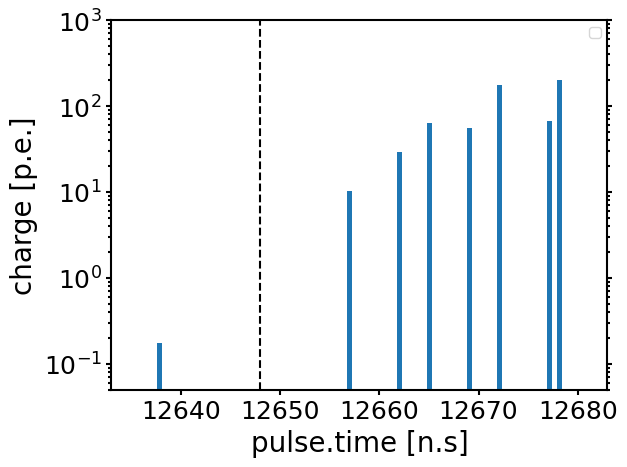

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


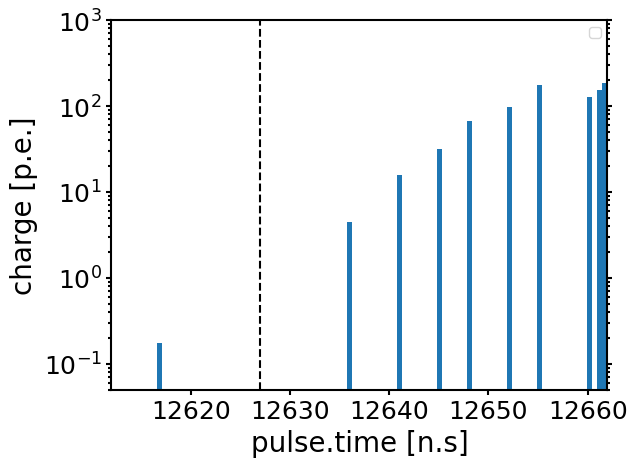

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


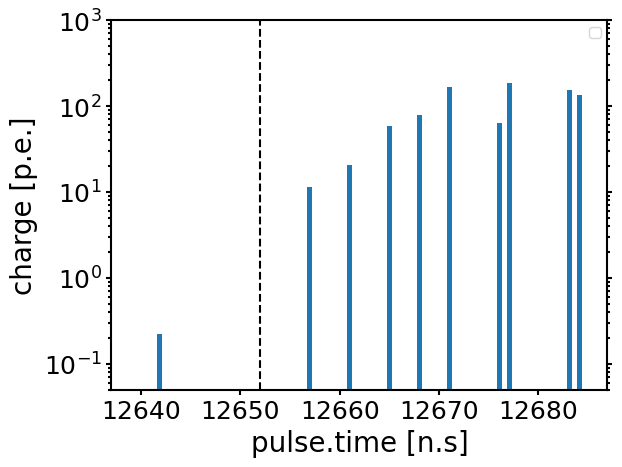

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


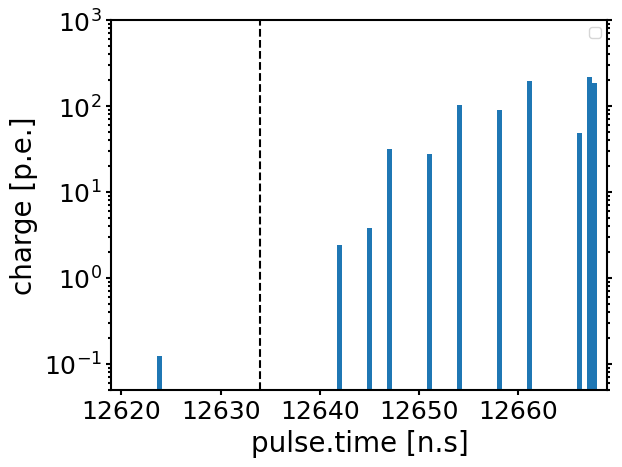

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


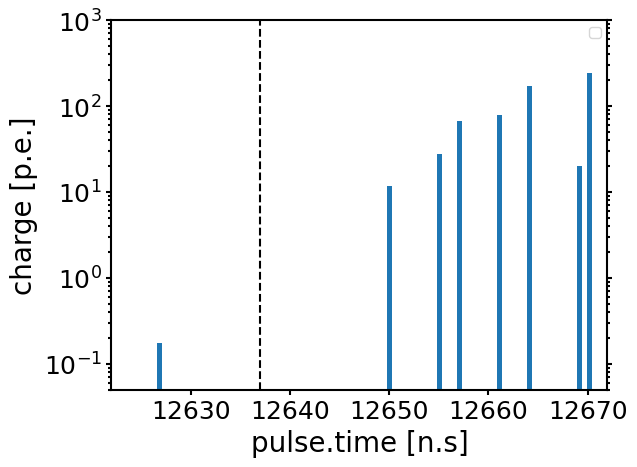

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


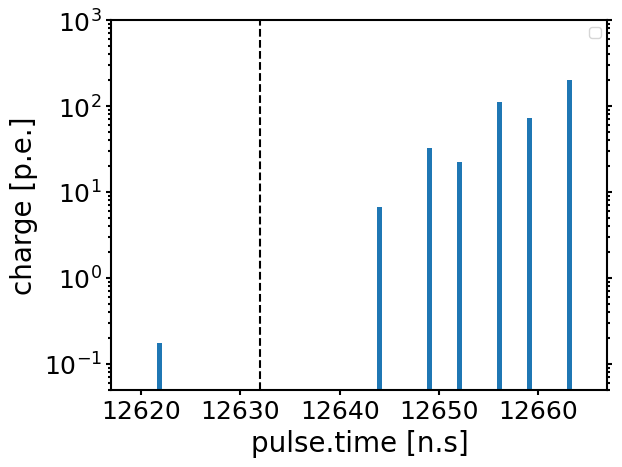

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


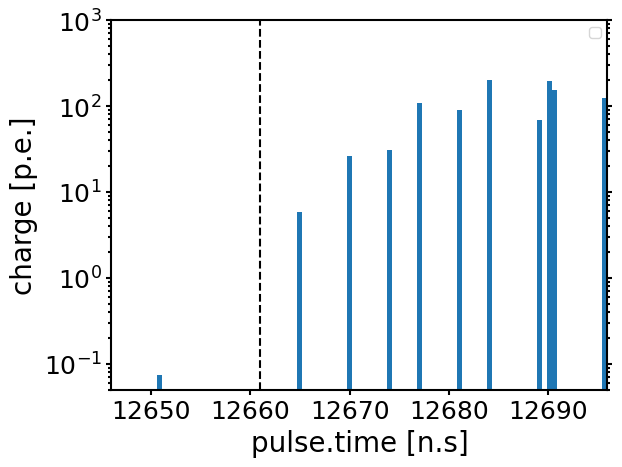

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


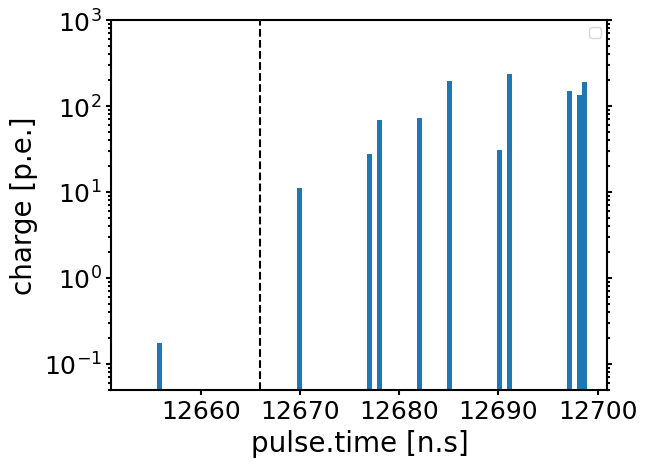

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


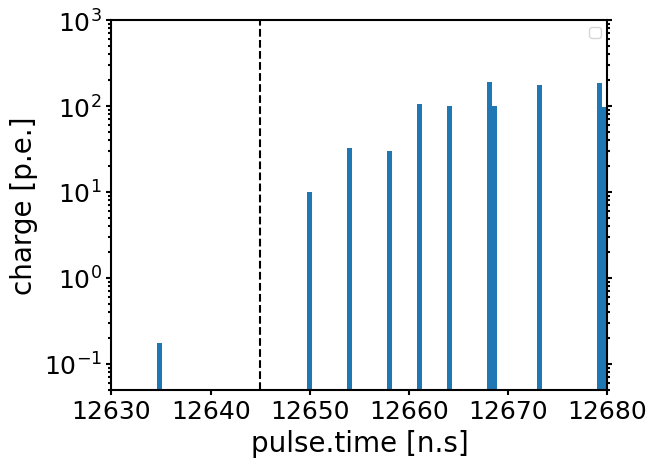

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


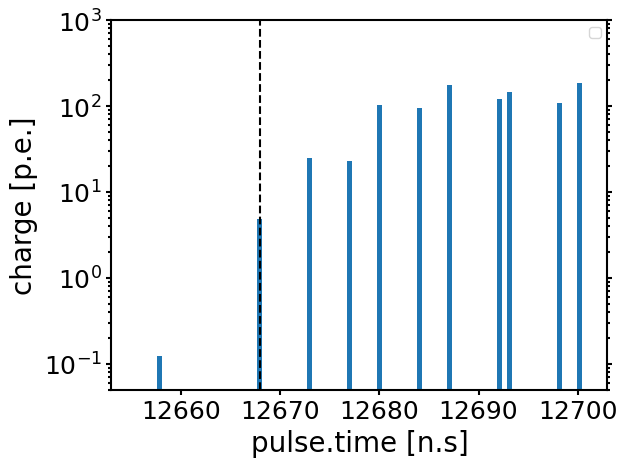

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


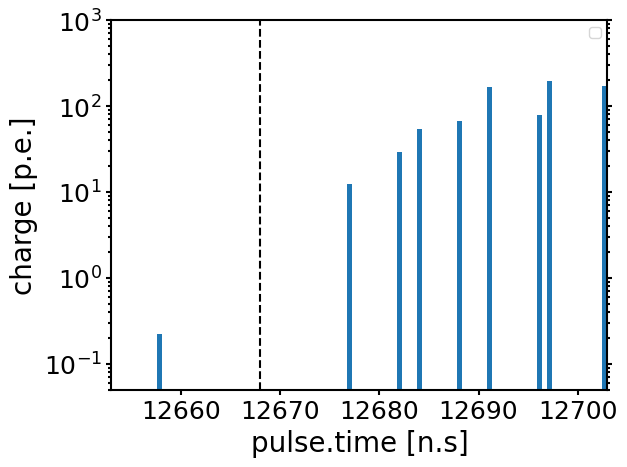

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


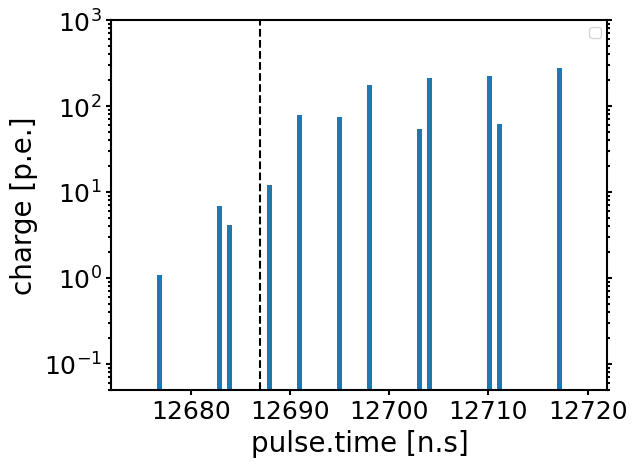

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


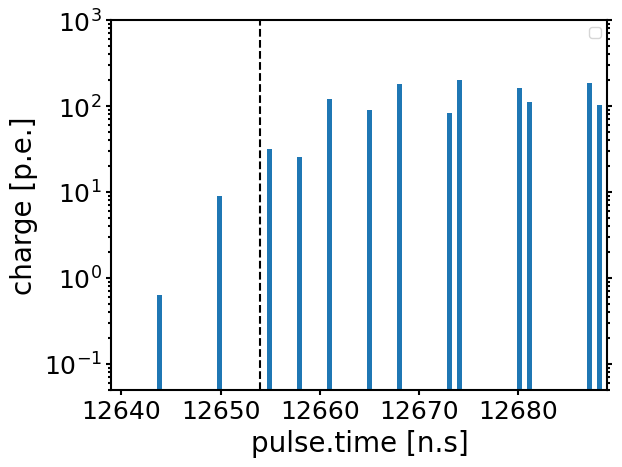

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


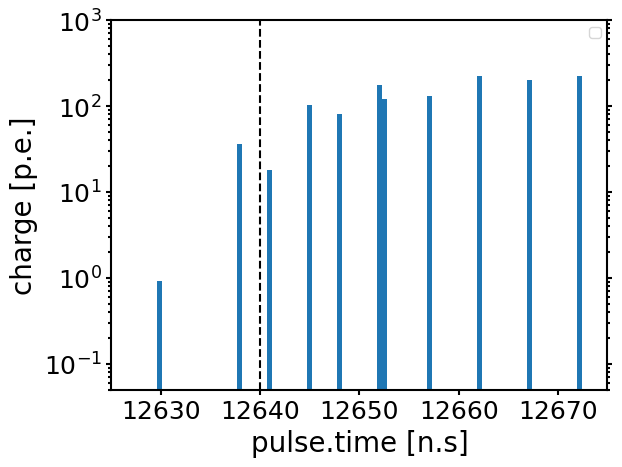

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


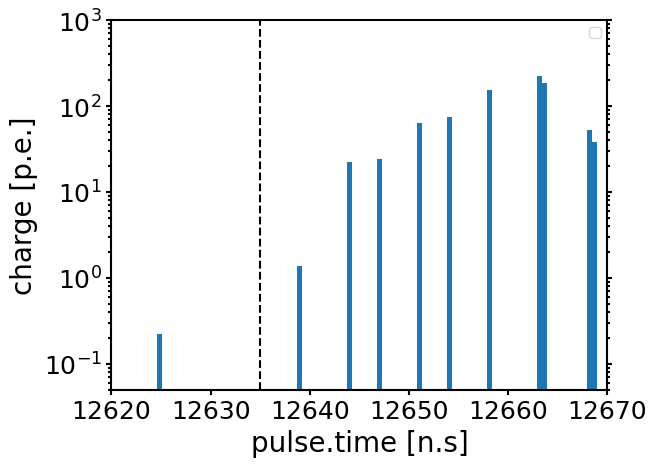

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


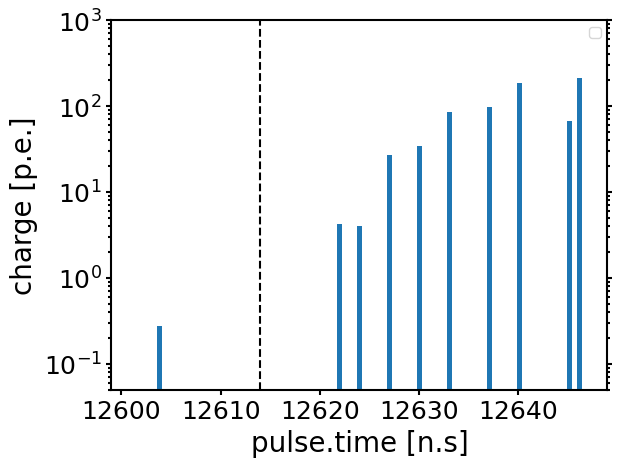

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


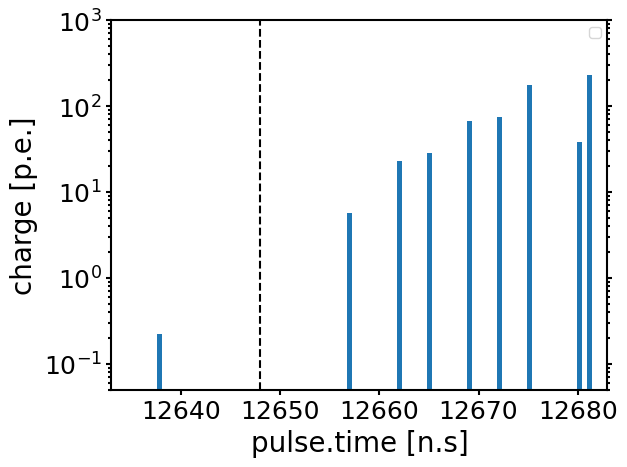

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


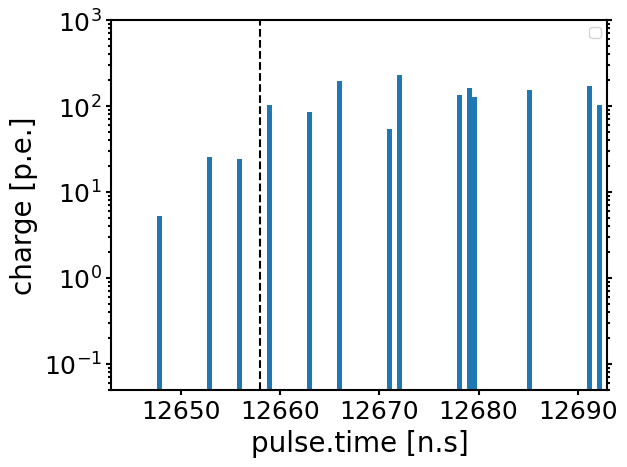

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


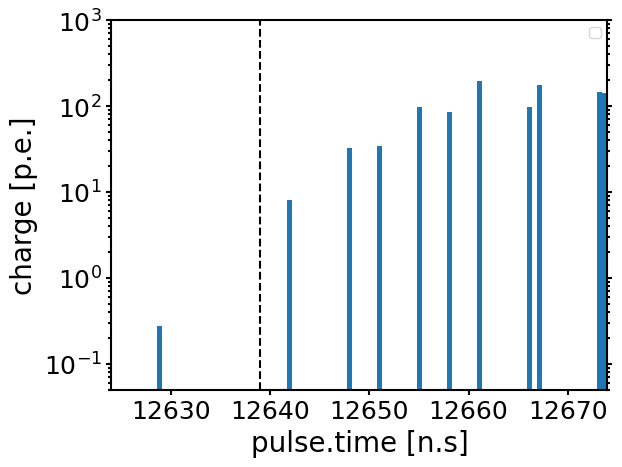

916.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


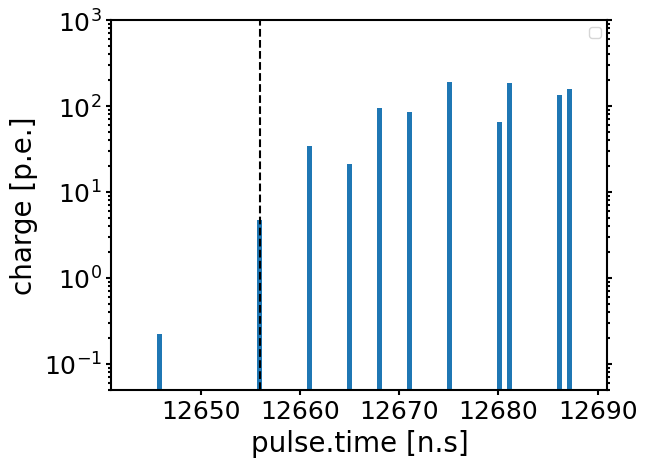

In [5]:
for i in range(20):
    meta, pulses = sim_handler.get_event_data(i)
    event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
    sensor_id_max_charge = event_data.loc[event_data['charge'].idxmax()]['sensor_id']
    print(sensor_id_max_charge)
    
    idx = pulses['sensor_id'] == sensor_id_max_charge
    
    pulses_this_dom = pulses[idx]
    min_t = pulses[idx]['time'].min()-5
    max_t = pulses[idx]['time'].max()+5
    bins = np.linspace(min_t, min(min_t + 50, max_t), 100)
    
    fig, ax = plt.subplots()
    
    ax.hist(pulses_this_dom['time'], bins=bins, weights=pulses_this_dom['charge'])
    ax.axvline(x=min_t+5+10, linestyle='dashed', color='black')
    
    plot_args = {'y_axis_in_log': True,
        'ylabel': 'charge [p.e.]',
        'xlabel': 'pulse.time [n.s]',
        'ylim': [0.05, 1000],
        'xlim': [min_t, min(min_t + 50, max_t)]}
    
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.show()

In [6]:
delta_times = [10, 15, 20]

hit_sid = []
hit_x = []
hit_y = []
hit_z = []
hit_t = []
hit_q = []
hit_frac_10 = []
hit_frac_15 = []
hit_frac_20 = []

for i in list(range(100)):
    try:
        meta, pulses = sim_handler.get_event_data(i)
    except:
        continue

    #print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

    track_time = meta['muon_time']
    track_pos = [meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']]
    track_dir = [meta['muon_zenith'], meta['muon_azimuth']]

    # Get dom locations, first hit times, and total charges (for each dom).
    #event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
    event_data = sim_handler.get_data_w_early_pulse_criterion(meta, pulses, delta_times)
    hit_sid.
    hit_t.append(event_data['time'].values - track_time)
    hit_x.append(event_data['x'].values)
    hit_y.append(event_data['y'].values)
    hit_z.append(event_data['z'].values)
    hit_q.append(event_data['charge'].values)
    hit_frac_10.append(event_data['ratio_10'].values)
    hit_frac_15.append(event_data['ratio_15'].values)
    hit_frac_20.append(event_data['ratio_20'].values)

In [7]:
    dom_data = defaultdict(lambda: defaultdict(list))

    for i in range(len(hit_x)):
        for j in range(len(hit_x[i])):
            x = hit_x[i][j]
            y = hit_y[i][j]
            z = hit_z[i][j]
            dom_data[(x,y,z)]['first_hit_time'].append(hit_t[i][j])
            dom_data[(x,y,z)]['q_tot'].append(hit_q[i][j])
            dom_data[(x,y,z)]['ratio_10'].append(hit_frac_10[i][j])
            dom_data[(x,y,z)]['ratio_15'].append(hit_frac_15[i][j])
            dom_data[(x,y,z)]['ratio_20'].append(hit_frac_20[i][j])

    for key in dom_data.keys():
        qs = dom_data[key]['q_tot']
        dom_data[key]['mean_q_tot'] = np.median(qs)

    sorting = 'distance'

    dom_pos = []
    for key in dom_data.keys():
        dom_pos.append(jnp.array(key).reshape((1,3)))

    dom_pos = jnp.concatenate(dom_pos, axis=0)
    track_pos = jnp.array(track_pos)
    track_dir = jnp.array(track_dir)

    # get also the other DOM info
    track_dir_xyz = get_xyz_from_zenith_azimuth(track_dir)

    geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
                cherenkov_cylinder_coordinates_w_rho_v(dom_pos,
                                             track_pos,
                                             track_dir_xyz)

In [8]:
    sorting = 'charge'

    # convert first_hit_times to delay_times by subtracting geo_times
    # and add more dom data to dom_data dict
    for i in range(len(dom_pos)):
        pos = tuple(np.array(dom_pos[i]))
        gt = geo_time[i]
        for j in range(len(dom_data[pos]['first_hit_time'])):
            dom_data[pos]['first_hit_time'][j] -= float(gt)

        dom_data[pos]['closest_approach_dist'] = closest_approach_dist[i]
        dom_data[pos]['closest_approach_rho'] = closest_approach_rho[i]
        dom_data[pos]['closest_approach_z'] = closest_approach_z[i]

    # charge sorted mapping
    dom_positions = list(dom_data.keys())

    if sorting == 'charge':
        dom_positions.sort(key=lambda x: dom_data[x]['mean_q_tot'], reverse=True)
    else:
        dom_positions.sort(key=lambda x: dom_data[x]['closest_approach_dist'] ,reverse=False)

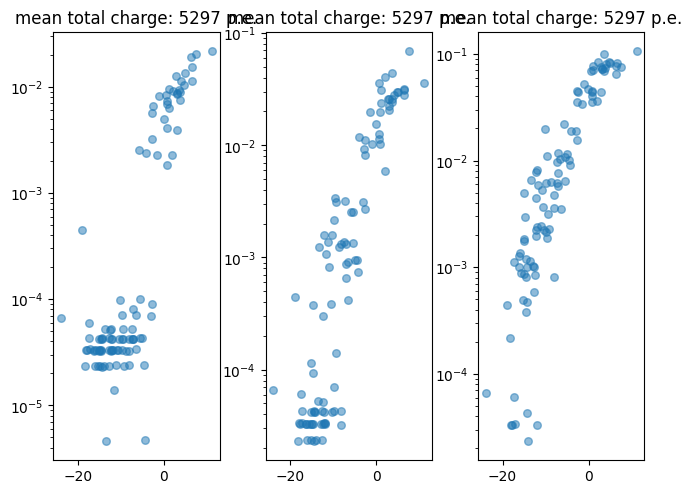

[3.29607197e-05 4.27772911e-05 3.29286242e-05 3.33355550e-05
 3.30491105e-05 3.27470054e-05 2.33511736e-05 3.33904145e-05
 6.64855715e-05 3.26092521e-05 3.36381585e-05 4.18503421e-05
 2.34443499e-05 6.01823968e-05 4.43569872e-04 2.35087239e-05]
[5309.3499916  5259.79996452 5314.52500992 5249.65002887 5295.14998917
 5344.00000481 5353.05000055 5241.02499019 5264.29999885 5366.57499151
 5202.42501144 5376.29999265 5331.77505445 5400.24999636 5297.92498302
 5317.17504597]


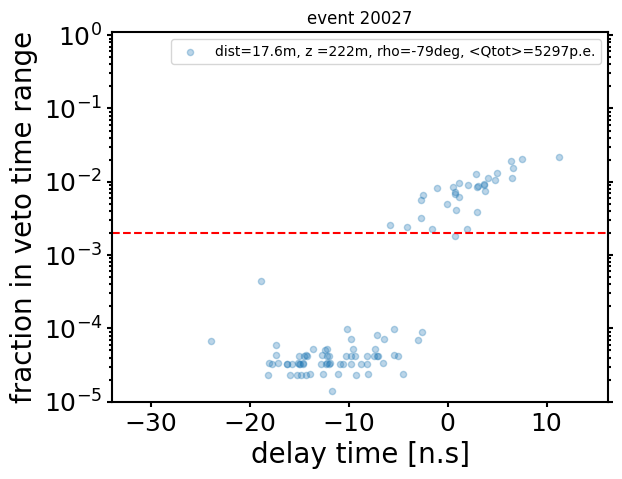

<Figure size 640x480 with 0 Axes>

[2.85534808e-05 3.90030807e-05 2.84279892e-05 2.77317123e-05
 2.84224948e-05 2.85243227e-05 3.90952239e-05 1.43034505e-04
 5.14774000e-05 2.82720677e-05 2.86746573e-05 2.86860086e-05
 5.07176533e-05]
[4377.7499826  4486.82498579 4397.0749855  4507.47500277 4397.92498851
 4382.22500515 4476.25002937 4369.57502246 4370.85000595 4421.32500887
 4359.25001049 4357.52501392 4436.32501468]


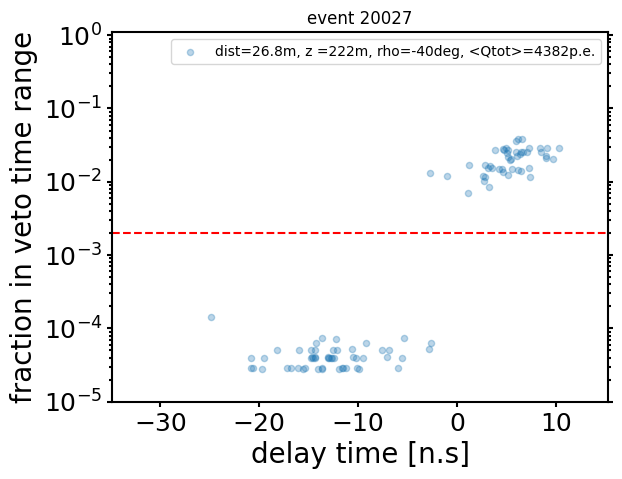

<Figure size 640x480 with 0 Axes>

In [17]:
pos = dom_positions[0]
data = dom_data[tuple(pos)]

fig, ax = plt.subplots(1 ,3)

for i in range(3):
    ax[i].scatter(data['first_hit_time'], data[f'ratio_{delta_times[i]}'], s=30, alpha=0.5)
    ax[i].set_title(f"mean total charge: {data['mean_q_tot']:.0f} p.e.")
    ax[i].set_yscale('log')

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=1.0)
plt.show()

for i in range(2):
    pos = tuple(dom_positions[i])
    data = dom_data[pos]

    dist = dom_data[pos]['closest_approach_dist']
    z = dom_data[pos]['closest_approach_z']
    rho = dom_data[pos]['closest_approach_rho']
    
    fig, ax = plt.subplots()
    
    for i in range(1):
        label = f"dist={dist:.1f}m, z ={z:.0f}m, rho={np.rad2deg(rho):.0f}deg, <Qtot>={data['mean_q_tot']:.0f}p.e."
        ax.scatter(data['first_hit_time'], data[f'ratio_{delta_times[i]}'], s=20, alpha=0.3, label=label)
        ax.set_title(f"event {event_id}")
        ax.set_yscale('log')

    idx = np.asarray(data['first_hit_time']) < -15
    print(np.asarray(data['ratio_10'])[idx])
    print(np.asarray(data['q_tot'])[idx])

    ax.axhline(y=2e-3, color='r', linestyle='dashed')

    min_t = max(-50, min(np.asarray(data['first_hit_time'])-10))
    max_t = max(data['first_hit_time'])+5
    
    plot_args = {'y_axis_in_log': True,
        'ylabel': 'fraction in veto time range',
        'xlabel': 'delay time [n.s]',
        'ylim': [1.e-5, 1.1],
        'xlim': [min_t, max_t]
        }
    
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.show()


    plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=1.0)
    plt.show()

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


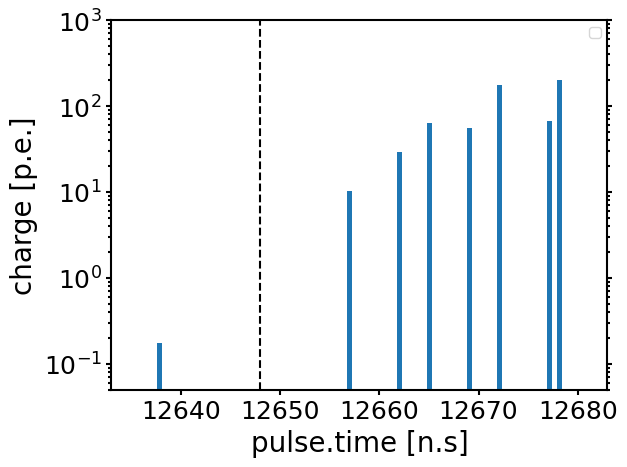

In [18]:
    i=0
    meta, pulses = sim_handler.get_event_data(i)
    event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
    sensor_id_max_charge = event_data.loc[event_data['charge'].idxmax()]['sensor_id']
    
    idx = pulses['sensor_id'] == sensor_id_max_charge
    
    pulses_this_dom = pulses[idx]
    min_t = pulses[idx]['time'].min()-5
    max_t = pulses[idx]['time'].max()+5
    bins = np.linspace(min_t, min(min_t + 50, max_t), 100)
    
    fig, ax = plt.subplots()
    
    ax.hist(pulses_this_dom['time'], bins=bins, weights=pulses_this_dom['charge'])
    ax.axvline(x=min_t+5+10, linestyle='dashed', color='black')
    
    plot_args = {'y_axis_in_log': True,
        'ylabel': 'charge [p.e.]',
        'xlabel': 'pulse.time [n.s]',
        'ylim': [0.05, 1000],
        'xlim': [min_t, min(min_t + 50, max_t)]}
    
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.show()

In [19]:
'''
def get_first_regular_pulse(pulses, t1, q_tot, crit_delta=10, crit_ratio = 2.e-3, crit_charge=300.):
    if q_tot < crit_charge:
        return t1
        
    n = len(pulses)
    charge = pulses['charge'].to_numpy()
    time = pulses['time'].to_numpy()

    q_veto = 0.0
    crit_time = time[0] + crit_delta
    i, j = 0, 0
    while j < n and time[j] <= crit_time:
        q_veto += charge[j]
        j += 1
    
    r_veto = q_veto / q_tot

    while i < n-1 and r_veto < crit_ratio:
        # remove early pulse
        q_tot -= charge[i]
        q_veto -= charge[i]

        # extend veto window
        t_crit = time[i+1] + crit_time
        while j < n and time[j] <= crit_time:
            q_veto += charge[j]
            j += 1

        crit_ratio = q_veto / q_tot
        i += 1
        
    return time[i]
'''

def get_first_regular_pulse(pulses, t1, q_tot, crit_delta=10, crit_ratio = 2.e-3, crit_charge=300.):
    # technically, if we do remove early pulses, one could correct the total charge.
    # in practice, this would be an epsilon correction. Not worth adding the extra code complexity.
    if q_tot < crit_charge:
        return t1

    n = len(pulses)
    charge = pulses['charge'].to_numpy()
    time = pulses['time'].to_numpy()

    j = 0
    q_veto = 0
    for i in range(0, n):
        crit_time = time[i] + crit_delta
        if j < i:
            j = i

        # extend window
        while j < n and time[j] < crit_time:
            q_veto += charge[j]
            j += 1

        r_veto = q_veto / q_tot
        if r_veto > crit_ratio:
            # found a reasonable pulse
            # break
            break

        # remove early pulse
        q_tot -= charge[i]
        q_veto -= charge[i]

    return time[i]

In [20]:
def replace_early_pulse(event_data, pulses):
    corrected_time = np.zeros(len(event_data))
    for i, row in event_data.iterrows():
        s_id = row['sensor_id']
        q_tot = row['charge']
        t1 = row['time']

        idx = pulses['sensor_id'] == s_id
        pulses_this_dom = pulses[idx]
        corrected_time[i] = get_first_regular_pulse(pulses_this_dom, t1, q_tot)

    event_data['time'] = corrected_time

In [21]:
i = 3
meta, pulses = sim_handler.get_event_data(i)
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

orig_times = event_data['time'].to_numpy().copy()

# do the replacement
replace_early_pulse(event_data, pulses)

In [22]:
event_data['delta_t'] = event_data['time'] - orig_times
event_data[['charge', 'delta_t']]
event_data.sort_values(by='charge').tail(20)

,sensor_id,charge,x,y,z,time,delta_t
655,3919,872.650004,303.41,335.64,189.56,10023.0,0.0
476,2777,878.000001,195.03,125.59,212.48,10884.0,0.0
477,2778,898.700005,195.03,125.59,195.46,10884.0,0.0
654,3918,990.225001,303.41,335.64,206.58,10036.0,0.0
373,2115,1044.724999,46.29,-34.88,245.66,11650.0,27.0
455,2717,1192.475008,90.49,82.35,212.31,11140.0,16.0
45,374,1266.675001,-334.80,-424.50,262.30,13445.0,10.0
376,2118,1271.775002,46.29,-34.88,194.60,11571.0,0.0
563,3378,1286.525003,257.31,211.66,198.05,10492.0,0.0
48,377,1295.925001,-334.80,-424.50,211.24,13399.0,0.0


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


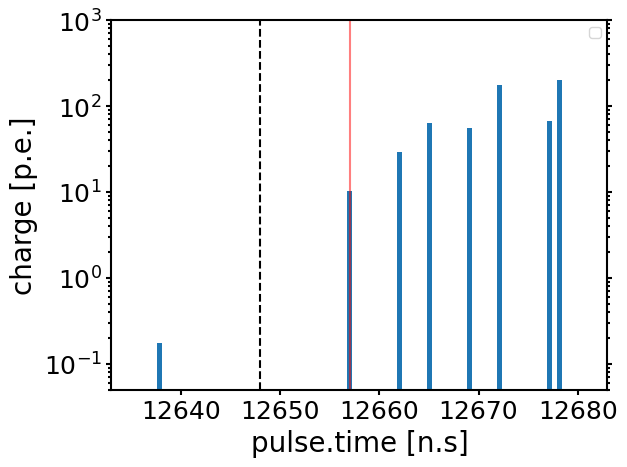

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


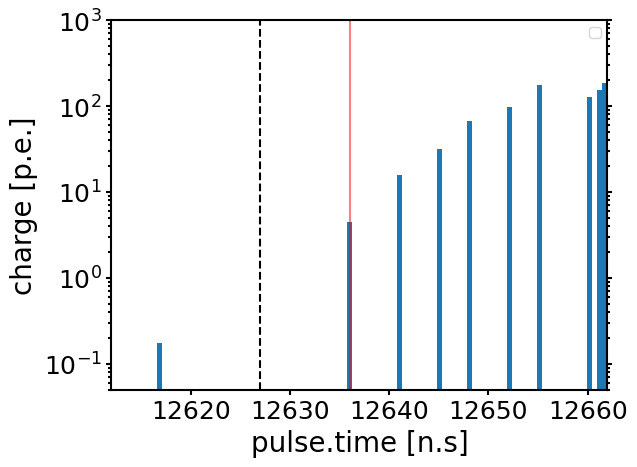

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


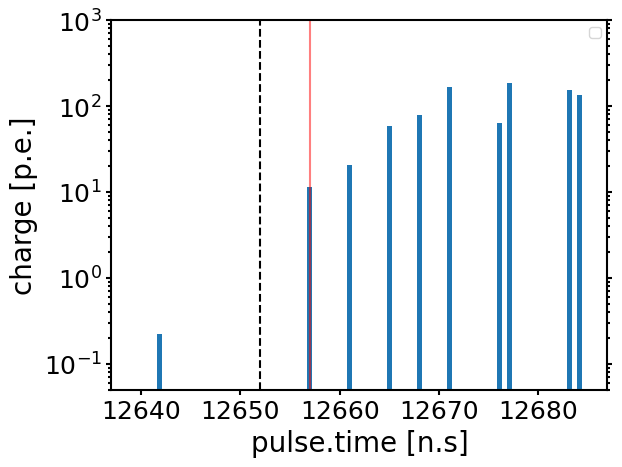

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


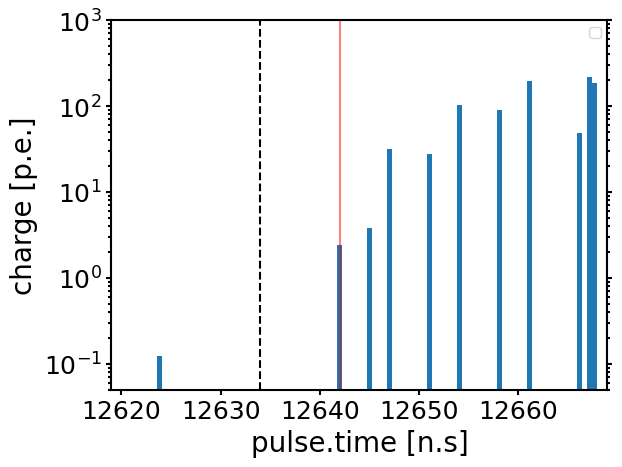

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


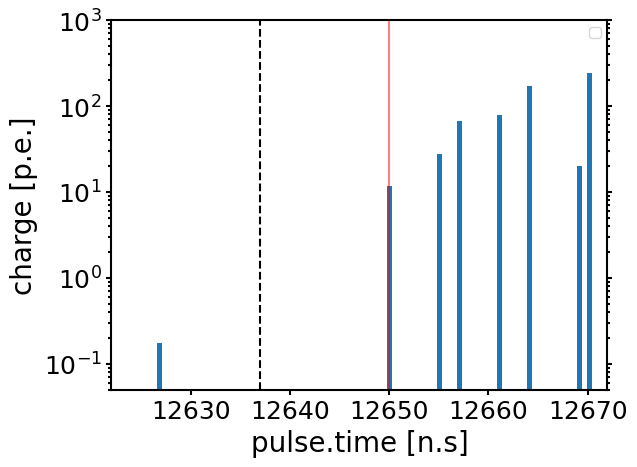

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


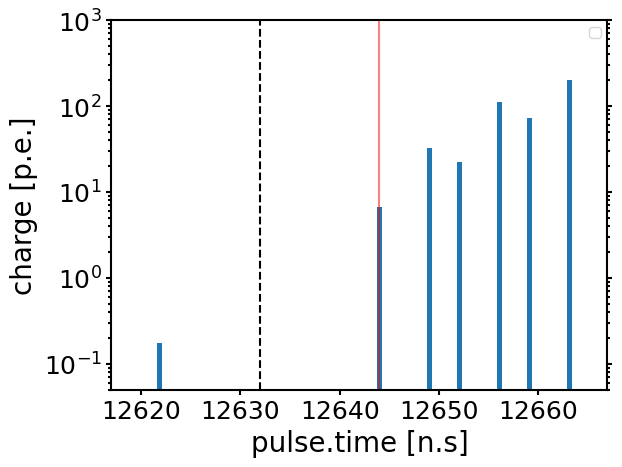

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


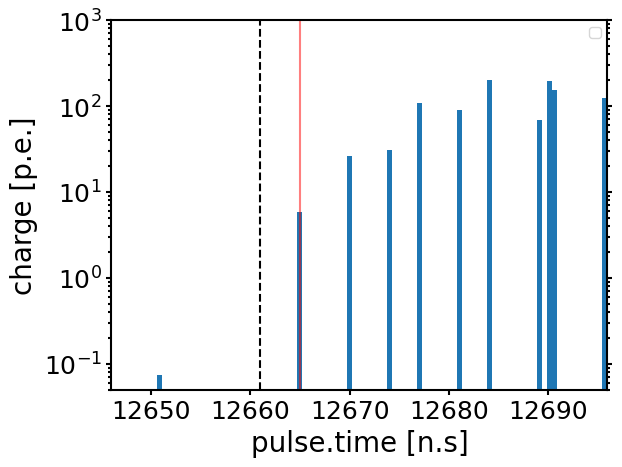

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


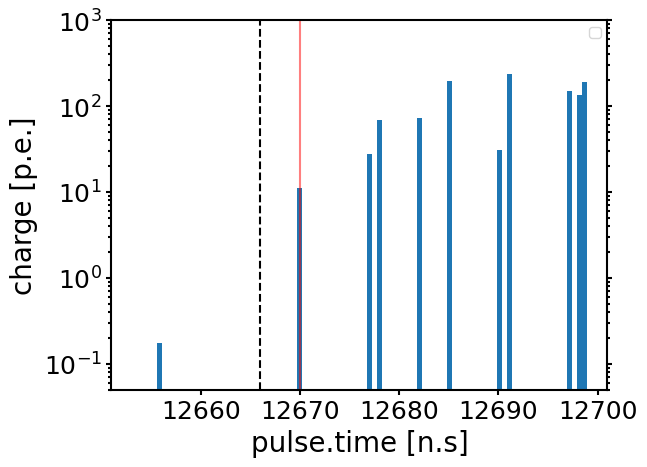

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


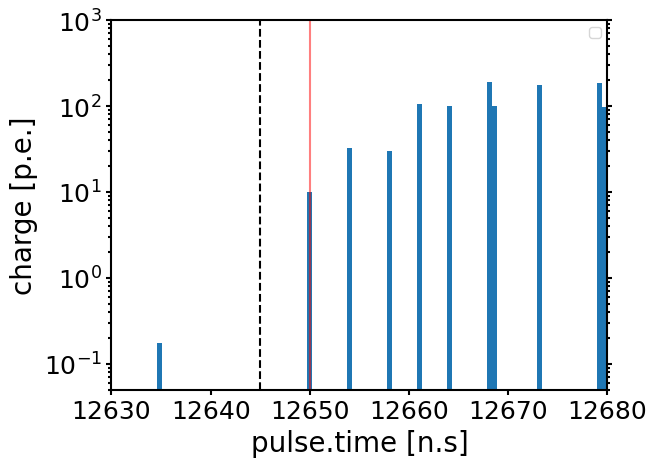

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


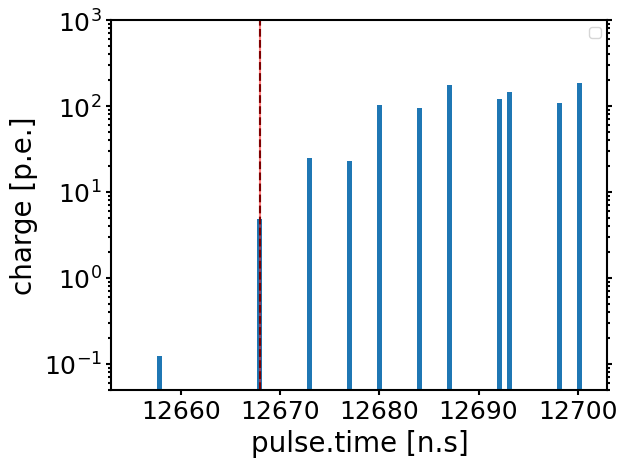

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


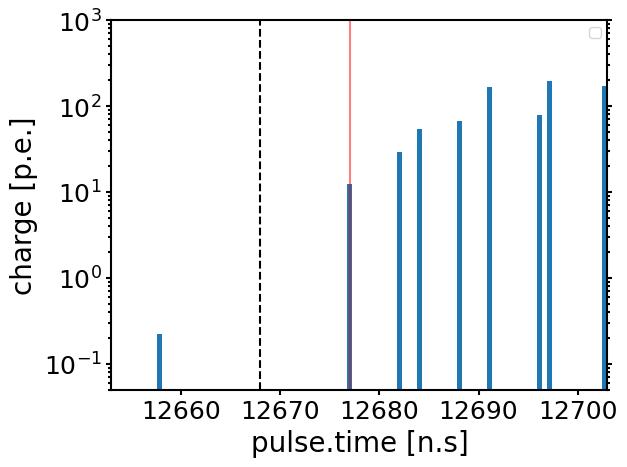

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


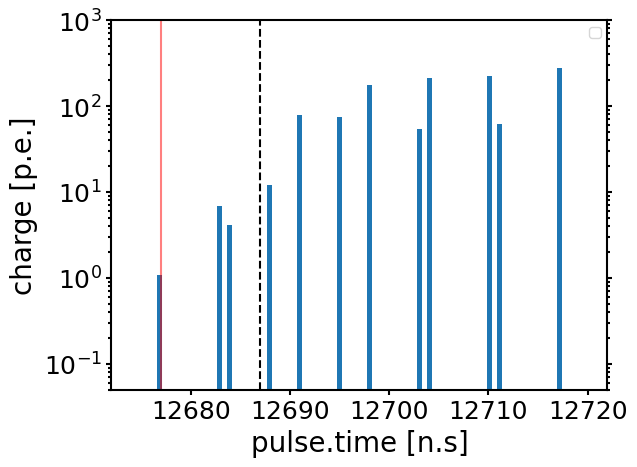

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


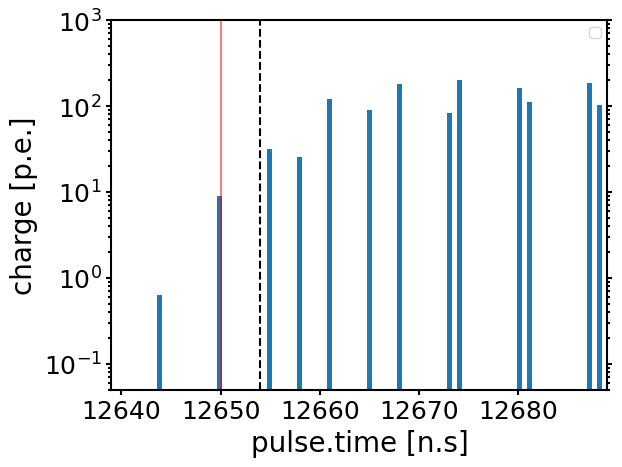

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


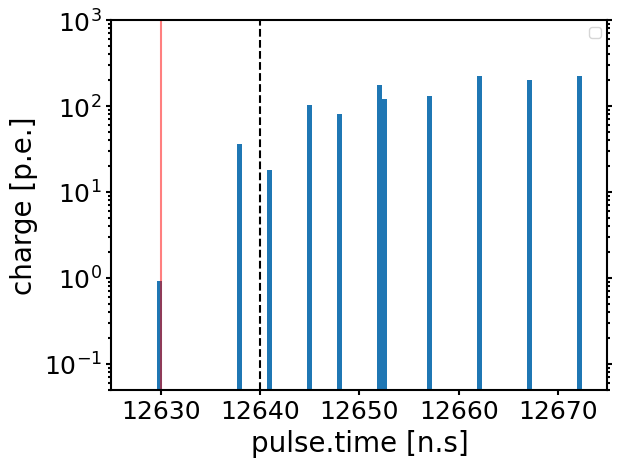

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


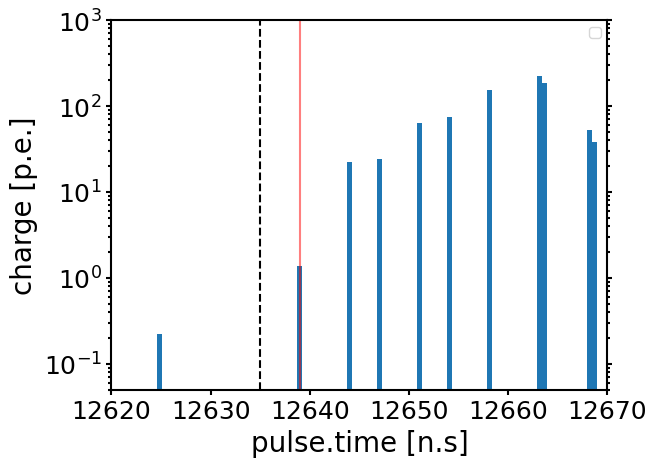

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


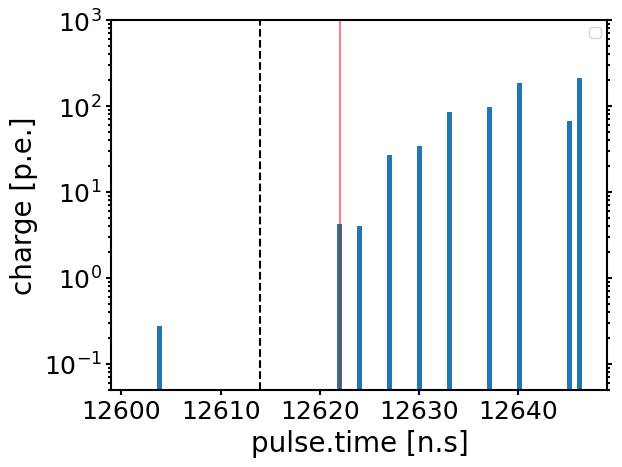

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


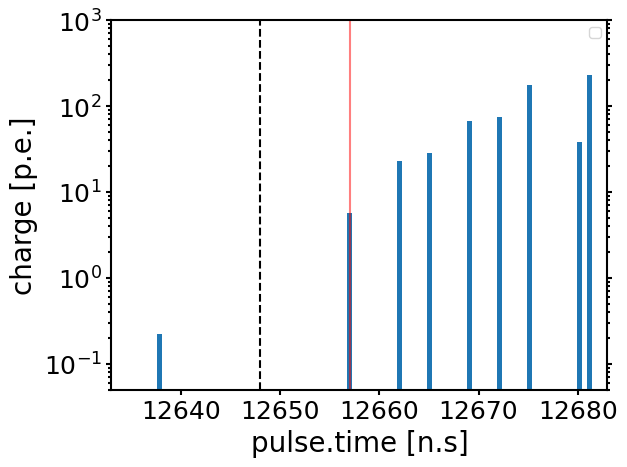

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


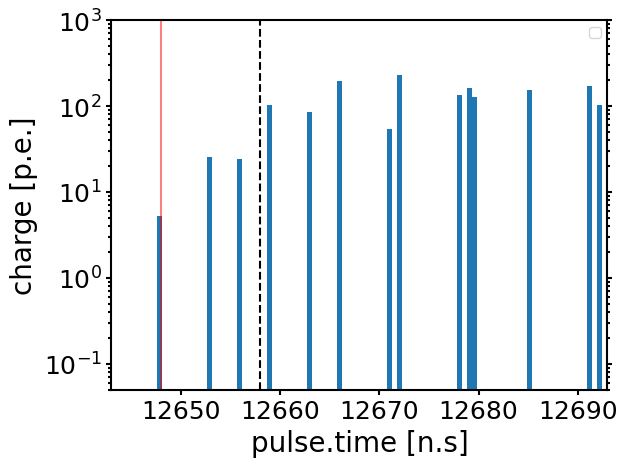

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


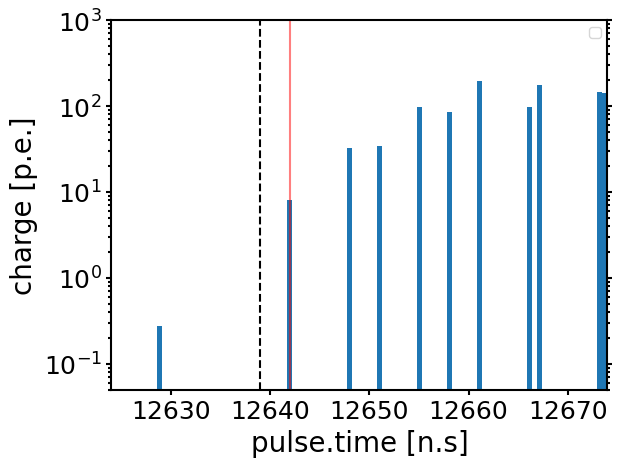

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


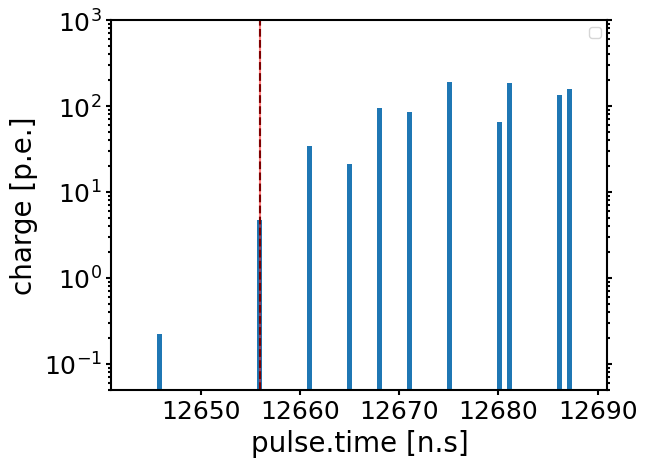

In [26]:
for i in range(20):
    meta, pulses = sim_handler.get_event_data(i)
    event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
    dom_data_max_charge = event_data.loc[event_data['charge'].idxmax()]
    sensor_id_max_charge = dom_data_max_charge['sensor_id']
    
    idx = pulses['sensor_id'] == sensor_id_max_charge
    
    pulses_this_dom = pulses[idx]
    min_t = pulses[idx]['time'].min()-5
    max_t = pulses[idx]['time'].max()+5

    fig, ax = plt.subplots()
    bins = np.linspace(min_t, min(min_t + 50, max_t), 100)   
    ax.hist(pulses_this_dom['time'], bins=bins, weights=pulses_this_dom['charge'])
    ax.axvline(x=min_t+5+10, linestyle='dashed', color='black')

    t1 = dom_data_max_charge['time']
    q_tot = dom_data_max_charge['charge']
    t1 = get_first_regular_pulse(pulses_this_dom, t1, q_tot)

    ax.axvline(x=t1, linestyle='solid', color='red', alpha=0.5)
    
    plot_args = {'y_axis_in_log': True,
        'ylabel': 'charge [p.e.]',
        'xlabel': 'pulse.time [n.s]',
        'ylim': [0.05, 1000],
        'xlim': [min_t, min(min_t + 50, max_t)]}
    
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.show()

